### set up dependencies

In [44]:
import numpy as np
import pandas as pd

import re
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

from gensim.models import Word2Vec

### get data

In [19]:
# load dataset into memory
def load_data (filename):
    df = pd.read_csv(filename)
    corpus = df["text"]
    target = df["label"]
    return corpus, target

corpus_valid, target_valid = load_data("IMDB/Valid.csv")
corpus_train, target_train = load_data("IMDB/Train.csv")
corpus_test, target_test = load_data("IMDB/Test.csv")

In [20]:
print("Possible sentiments are", np.unique(target_train))
print("The number of reviews for training is", len(corpus_train))
size = len(corpus_train) + len(corpus_valid) + len(corpus_test)
print("Training corpus is " + str(int(100*np.sum(target_train)/len(target_train))) + "% positive reviews")
info = pd.DataFrame([corpus_train[5]], columns=["raw text example"]) # use to track progress
info

Possible sentiments are [0 1]
The number of reviews for training is 40000
Training corpus is 49% positive reviews


,raw text example
0,A terrible movie as everyone has said. What ma...


### clean up data

In [21]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

# turn the dataset into clean tokens
def clean_data(doc):
    doc = re.sub(r'<[^>]+>', '', doc)  # remove HTML tags
    doc = re.sub(r'\W+', ' ', doc) # remove special characters
    
    # lemmatize tokens and exclude stop words
    #tokens = [lemmatizer.lemmatize(word) for word in doc.split() if word.lower() not in stop_words]
    tokens = [word.lower() for word in doc.split() if word.lower() not in stop_words]

    # put tokens back into string format for tfidf vectorizer
    clean_doc = " ".join(tokens)

    return clean_doc

In [22]:
X_train = []
y_train = target_train
for line in corpus_train:
    clean_line = clean_data(line)
    X_train.append(clean_line)

X_valid = []
y_valid = target_valid
for line in corpus_valid:
    clean_line = clean_data(line)
    X_valid.append(clean_line)

X_test = []
y_test = target_test
for line in corpus_test:
    clean_line = clean_data(line)
    X_test.append(clean_line)

In [6]:
info["clean text example"] = X_train[5]
info["sentiment"] = y_train[5]
review_len = [sum(1 for word in review.split()) for review in X_train]
info["num tokens in corpus"] = np.sum(review_len)
info["avg review length"] = np.mean(review_len)
info["max review length"] = np.max(review_len)
info["min review length"] = np.min(review_len)
info

,raw text example,clean text example,sentiment,num tokens in corpus,avg review length,max review length,min review length
0,A terrible movie as everyone has said. What ma...,terrible movie everyone said made laugh cameo ...,0,4786521,119.663025,1429,3


## TF-IDF

In [50]:
def define_model_tfidf(size):
    model_tfidf = Pipeline([
        ("vect", TfidfVectorizer(min_df=0.1)), 
        ("clf", MLPClassifier(hidden_layer_sizes=(size,), max_iter=500))
    ])
    model_tfidf.fit(X_train, y_train)
    predict_train = model_tfidf.predict(X_train)
    train_accuracy = accuracy_score(y_train, predict_train)
    
    predict_valid = model_tfidf.predict(X_valid)
    valid_accuracy = accuracy_score(y_valid, predict_valid)
    return model_tfidf, train_accuracy, valid_accuracy

In [51]:
model_tfidf100, train_accuracy100, valid_accuracy100 = define_model_tfidf(100)
model_tfidf200, train_accuracy200, valid_accuracy200 = define_model_tfidf(200)
#model_tfidf500, train_accuracy500, valid_accuracy500 = define_model_tfidf(500)

/Users/teodorastereciu/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/teodorastereciu/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [54]:
print("model100:", train_accuracy100, valid_accuracy100)
print("model200:", train_accuracy200, valid_accuracy200)
#print("model500:", train_accuracy500, valid_accuracy500)

model100: 0.91355 0.6918
model200: 0.998525 0.681


455
460
746


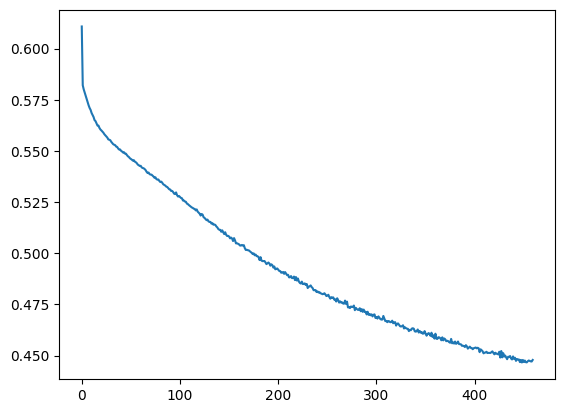

In [ ]:
print(model_tfidf100['clf'].n_iter_) #455
print(model_tfidf200['clf'].n_iter_) #460
print(model_tfidf500['clf'].n_iter_) #746

from sklearn.model_selection import learning_curve
loss_values = model_tfidf200['clf'].loss_curve_

import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.show()

# Word2Vec

In [ ]:
# tokenize for word2vec
X_train_list = [[word for word in line.split()] for line in X_train]
# initialize the word2vec model
w2v_model = Word2Vec(X_train_list,
                    vector_size=100,
                    window=5,
                    min_count=2)

In [74]:
def w2v_vectorizer(X):

    X_list = [[word for word in line.split()] for line in X]
    
    # average embeddings for each review
    X_vect = []
    vocab = set(w2v_model.wv.index_to_key)
    for line in X_list:
        mean_vec = [0]*100
        for word in line:
            if word in vocab:
                mean_vec = np.add(mean_vec, w2v_model.wv[word])
        X_vect.append(np.array(mean_vec/len(line)))

    return np.array(X_vect)

In [75]:
X_train_vect = w2v_vectorizer(X_train[0:100])

print(X_train_vect)

[[-0.44250308 -0.12474672 -0.11875592 ... -0.12294614 -0.01942103
   0.0104833 ]
 [-0.62371868 -0.46918127 -0.41876    ...  0.14540264  0.15781565
  -0.41587733]
 [-0.77591374 -0.39079838 -0.33819434 ...  0.26265447  0.13211061
  -0.38795699]
 ...
 [-0.30249076 -0.11166037 -0.14121279 ...  0.25851835  0.15269776
  -0.36960565]
 [-0.9231643  -0.41026558 -0.67779348 ...  0.26594043  0.32524223
  -0.42071024]
 [-0.4394797  -0.19827351 -0.24165958 ...  0.09765698  0.37199169
  -0.01631636]]


In [78]:
def define_model_w2v():
    X_train_vect = w2v_vectorizer(X_train)
    clf_w2v = MLPClassifier(hidden_layer_sizes=(200,))
    clf_w2v.fit(X_train_vect, y_train)
    
    predict_train = clf_w2v.predict(X_train_vect)
    train_accuracy = accuracy_score(y_train, predict_train)

    X_valid_vect = w2v_vectorizer(X_valid)
    predict_valid = clf_w2v.predict(X_valid_vect)
    valid_accuracy = accuracy_score(y_valid, predict_valid)
    return clf_w2v, train_accuracy, valid_accuracy
    

In [79]:
model_w2v, train_accuracy_w2v, valid_accuracy_w2v = define_model_w2v()
print(train_accuracy_w2v, valid_accuracy_w2v)

/Users/teodorastereciu/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.950875 0.8456
